## Gifsplanation

Gifsplanation is a method proposed [here](https://doi.org/10.48550/arXiv.2102.09475) as a means of generating counterfactuals by shifting the latent representation in the direction that causes the most change in class. In this way, by making use of an encoder and decoder, we can generate images that show the visual changes that would lead to a higher prediction confidence in a class.

We already have an encoder which will be the backbone from our trained model. There are some benefits to using this model, primarily that the CAVs we have generated will have meaning in the latent space of the model. This means that we can hopefully pass the CAVs through and influence the activations to cause changes in the image in the direction of the CAVs. This will hopefully show us the visual features that the CAVs represent.

So we will need to allow for values to be added to the activations in the layers that we used as bottleneck layers for our automated concept extraction method. To facilitate this I have copyed the ResNet implementation that the Faster R-CNN model is using and made alterations to allow for a decoder and for values to be added to the intermediate activations. This file, resnet.py, has been included in the torchvision files folder in the Utils within the repo.

Ideally, we will create an autoencoder that can create realistic looking reconstructions that we can alter by passing in some combination of the CAVs and gradients from the images. Theoretically, if we pass the gradients for a prediction we can hopefully only influence that portion of the image/tile. This is something I will have to experiment with.

### Imports

We will be making use of some PyTorch modules and loading in our modified ResNet and some training files.

In [12]:
import pickle
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

from Utils.Torchvision_files.resnet import resnet50
import Utils.ACE.ace_helpers as ace_helpers
from Utils.Training.dataset import MidogDataset, transforms
from Utils.Training.training import train_ae
import Utils.Training.utils as utils

### Loading in the trained model

We want to make use of the backbone from our trained model, so we will load it in and isolate the backbone and take the weights into a new ResNet50 model. This new model will have no Feature Pyramid Network, but this is not important as we don't need activations for multiple layers to aid in detection, we only need the activations from the final layer to pass to the decoder for reconstruction.

In [2]:
%%capture
# Load the old model in.
bottleneck_layers = ['backbone.body.layer4.2.conv1']

# Create the model variable and set it to evaluate.
mymodel = ace_helpers.MyModel("mitotic", bottleneck_layers)
mymodel.model.eval()
mymodel.model.model

In [3]:
# Take the transform for our original model, this will ensure that activations are the same.
transform = mymodel.model.model.transform

# Let us define the inverse of this transform so we can return to the original image once we have output.
inv_transform = invTrans = T.Compose([T.Resize((512, 512)),
                                      T.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                      T.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

# Take the backbone from our trained model.
backbone = mymodel.model.model.backbone.body

We want to make sure we take the transform from the model as this was applied during the training of the backbone, so it is important to keep it consistent. We also need an inverse of this transform so we can recover images from the model.

### Create the new ResNet AutoEncoder

Now we can load in our custom RenNet model and view the architecture. I made use of the [Torchxrayvision implementation](https://github.com/mlmed/torchxrayvision/blob/master/torchxrayvision/autoencoders.py) and found an implementation that contained training code [here](https://github.com/AlexPasqua/Autoencoders) which I altered for my use case. 

In [4]:
# Take a new ResNet50 model.
resnet_backbone = resnet50()

In [5]:
resnet_backbone

ResNetAE(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): BottleneckInsertValues(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

Now we can load the state from our trained backbone into our ResNet autoencoder. The encoder layers are identical to the layers used in the backbone and so we can copy the weights exactly, the other layers are initialized from scratch.

In [6]:
%%capture
# Load the state from the backbone from our model.
resnet_backbone.load_state_dict(backbone.state_dict(), strict=False)

# NOTE: We are missing the fully connected layer weights and biases, but this is okay as we will just take the activations from
# the last bottleneck layer.

It is important that we freeze the encoder layers by setting the require_grad attribute to False. This will ensure that no gradients are calculated for these tensors of parameters and will make sure they maintain their trained values.

In [7]:
end_of_encoder = False

for name, child in resnet_backbone.named_children():
    
    if name == "uplayer1":
        end_of_encoder = True
        
    if not end_of_encoder:
        for param in child.parameters():
            param.requires_grad = False
            
    else:
        for param in child.parameters():
            param.requires_grad = True

We will now remove the trained model and empty the cache as it is taking up GPU memory that is needed during training.

In [8]:
del mymodel
torch.cuda.empty_cache()

### Loading in the Dataset

The dataset that we defined during the model training can be used again here, I have saved it as a script in the Utils folder in the repo for use across scripts and notebooks. We will train the autoencoder to reconstruct the images we pass through the encoder by making use of the Mean Squared Error, which calculates how well the resultant image overlaps with the original.

In [9]:
# Create a Dataset object with the given root path to the training data and a defined transformation.
midog = MidogDataset("D:/DS/DS4/Project/Training_mitotic_figures", transforms)

The model can now be trained by passing the model, dataset, transforms, batch size, epochs to run for, output path and the path to a checkpoint if there is one. This will allow the model training to stop and restart again if needed.

In [13]:
autoencoder_saves = Path("D:/DS/DS4/Project/AutoEncoder")

In [ ]:
metrics = train_ae(resnet_backbone, midog, transform, inv_transform, bs=2, num_epochs=20, output_path=autoencoder_saves, checkpoint=autoencoder_saves / "ResNetAE_2023_05_05_19_39_22_35.pth")

  7%|█████▎                                                                         | 226/3400 [02:19<29:43,  1.78it/s]

We can look at a plot of the losses for the model training. We can see that there has been no improvement in the validation loss since early epochs, but this is okay as we just want a model that can make valid reconstructions for our use case.

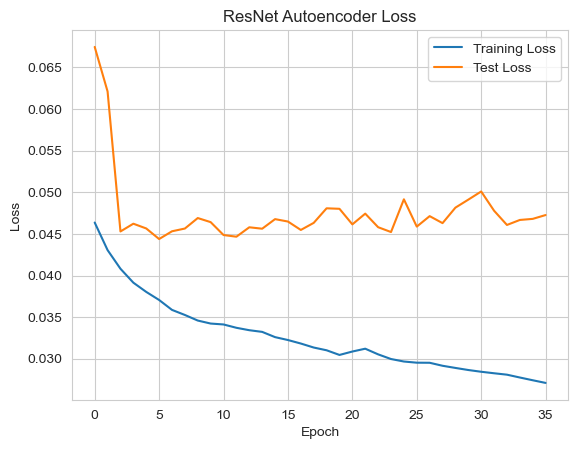

In [14]:
metrics_path = autoencoder_saves / "ResNetAE_2023_05_05_19_39_22_35_metrics.pkl"

with open(metrics_path, 'rb') as handle:
    metrics = pickle.load(handle)

training_loss = metrics["tr_loss"]
validation_loss = metrics["val_loss"]

sns.set_style("whitegrid")
    
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('ResNet Autoencoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper right')
plt.show()

matplotlib.rc_file_defaults()

In [24]:
checkpoint = torch.load("D:/DS/DS4/Project/AutoEncoder/ResNetAE_2023_05_05_19_39_22_35.pth", map_location=lambda storage, loc: storage)

resnet_backbone.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

We can use the above to load the saved weights from a checkpoint directly into the model if we don't want to train it further.

### Testing the reconstruction

Making use of the dataloader, we can pass an image to the autoencoder and view the returned image against the original. This will allow us to visually assess the quality of the reconstructions.

In [25]:
# Create a DataLoader with the dataset with a batch size of 2, no shuffling and use a custom defined collate_fn to batch
# the output as desired.
data_loader = DataLoader(midog, batch_size=1, shuffle=False, collate_fn=utils.collate_fn)

# Create an iterator from the DataLoader
data = iter(data_loader)

In [26]:
# Take the next image batch (of size 1)
output = next(data)

This image now has to undergo the same transformation used during training and in the original trained Faster R-CNN model. This can then be passed to the GPU with the model and the output returned from the model.

In [27]:
# Transform the image batch.
imgs, targets = transform(output[0], output[1])

In [28]:
# Move the image and model to the GPU.
cuda_imgs = imgs.tensors.to("cuda")
resnet_backbone.to("cuda")

ResNetAE(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): BottleneckInsertValues(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

In [29]:
# Pass the image to the autoencoder.
results = resnet_backbone(cuda_imgs)

In [30]:
# Use the inverse transform on the original image
original = inv_transform(imgs.tensors)
result = inv_transform(results) 

In [31]:
# Create a transform to convert the tensors to PIL images.
pil_transform = T.ToPILImage()

# Transform the tensors to PIL images.
original_img = pil_transform(torch.squeeze(original)) # imgs
reconstructed_img = pil_transform(torch.squeeze(result))

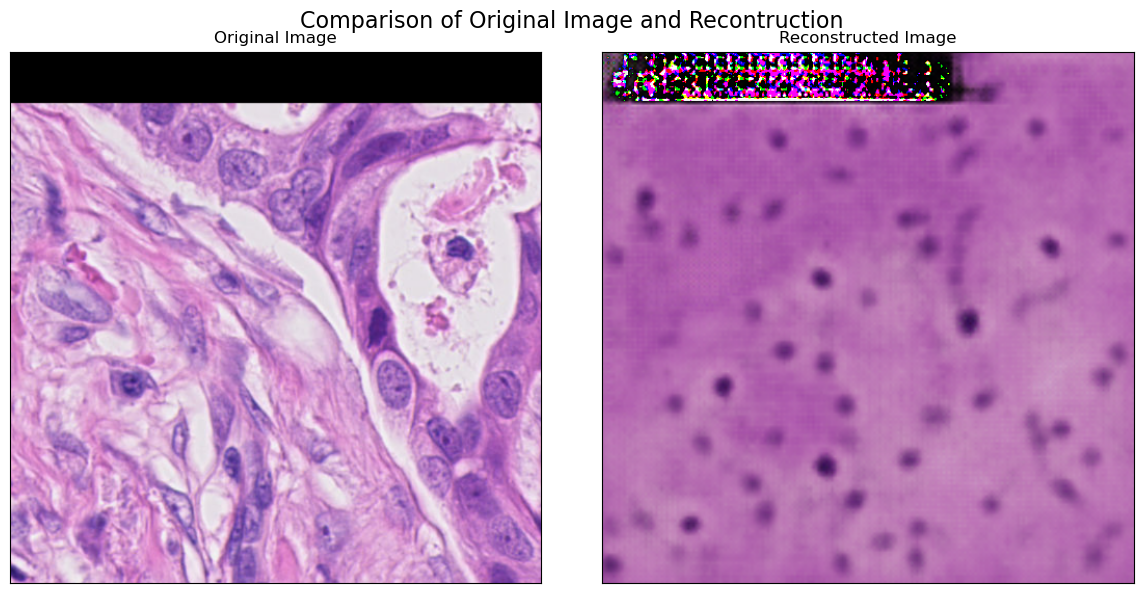

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].imshow(original_img)
ax[1].imshow(reconstructed_img)

ax[0].set_title('Original Image')
ax[1].set_title('Reconstructed Image')

ax[0].tick_params(left=False, bottom=False)
ax[1].tick_params(left=False, bottom=False)

ax[0].set(yticklabels=[], xticklabels=[])
ax[1].set(yticklabels=[], xticklabels=[]) 

title = 'Comparison of Original Image and Recontruction'
fig.suptitle(title, fontsize=16)
plt.tight_layout()
plt.show()

We can see that the recontructed image appears quite similar to the original, just not as clear and lacking texture and pores. This shows us that the model has learned how to convert the encoding we originally had in our model back to an approximate reconstruction that contains the nuclei of cells at the least.

Ideally, we will be able to alter the intermediate activations and perceive changes in the reconstructions that seem plausible given the values added.

### Deciding on addition to the intermediate activations

There are several interesting angles to take here. I have concept activation vectors that are meaningful in the space within my encoder and an encoder that has been trained on a task with multiple outputs, the detections of mitotic figures. I believe the most interesting application considering the standings is to make use of some combination of the CAV in the direction of the gradients. The motivation would be to influece a detection, whose gradients we find, in the direction that the CAV causes influence. This will theoretically alter the image in only the portion of interest and in a way that represents the visual feature of the CAV.

I will look at this in incremental stages, first testing if the gradients can in fact alter only the relevant portion of an image. Next I will implement a small portion of an influential CAV to the activations along with the gradients. The motivation for this is that the CAV should influence the portion of the image relating to the detection. Regardless, I am excited to see if the results are meaningful or just distored reconstructions.

### Passing the gradients in

This will involve making use of our original model and returning the gradients for an image. These can then be fed into our autoencoder to produce images that are modified in the direction of the gradient.

In [39]:
# Load in our model and only pass the final bottleneck layer for use.
bottleneck_layers = ['backbone.body.layer4.2.conv1']

# Create the model variable and set it to evaluate.
mymodel = ace_helpers.MyModel("mitotic", bottleneck_layers)
mymodel.model.eval()
mymodel.model.model

mymodel.model.to("cuda")

In [40]:
# Load in our dataset again
data_loader = DataLoader(midog, batch_size=1, shuffle=False, collate_fn=utils.collate_fn)

img, target = midog[5500]    

In [41]:
cuda_img = img[None, :].to("cuda")

# Pass the images to the model.
predictions, _ =  mymodel.model(cuda_img)

# Generate the gradients for the image for the given class id.
gradients, info = mymodel.model.generate_gradients(1)

In [42]:
predictions

[{'boxes': tensor([[269.1402, 310.2549, 318.9763, 360.1942],
          [442.7667,  50.6358, 508.2864, 117.8740],
          [ 86.2943,  58.7854, 136.2595, 108.5908],
          [129.1386, 157.9896, 179.1597, 207.5701],
          [462.9586,  47.5414, 505.2534,  99.1865],
          [457.0221,  66.9618, 500.1829, 118.6983]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9848, 0.9651, 0.8745, 0.2316, 0.1539, 0.0862], device='cuda:0',
         grad_fn=<IndexBackward0>)}]

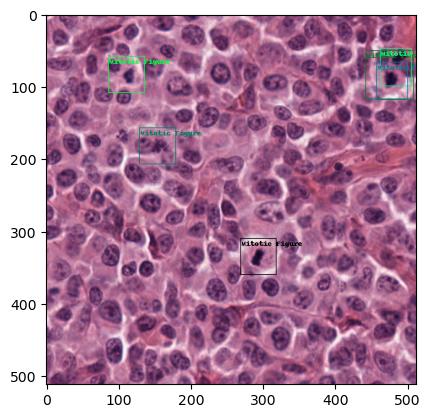

In [43]:
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

# Pull the boxes out of the prediction.
boxes = predictions[0]["boxes"]

# These labels were manually entered.
labels = ["Mitotic Figure", "Mitotic Figure",  "Mitotic Figure",  "Mitotic Figure",  "Mitotic Figure",  "Mitotic Figure"]

# Take just the first image, which just involves removing the first dimension which corresponds to the number of images.
# which is 1 in our case. Squeeze removes dimensions of length 1.
example = torch.squeeze(img.to("cpu"))

# Convert it to int8. 
example = T.ConvertImageDtype(torch.uint8)(example)

img_with_boxes = draw_bounding_boxes(example, boxes, labels)

plt.imshow(img_with_boxes.permute(1, 2, 0))

We can see that for the can see that for the current image we have got 6 predictions, only 2 of which have a high confidence. We can use the gradients produced by both of these separately to determine if we can influence the image in these regions specifically.

In [44]:
del mymodel
torch.cuda.empty_cache()

In [45]:
img, target = transform(img[None, :], [target])

Now we can add a small proportion of the gradient to the image to allow for us to generate interesting images.

In [46]:
import numpy as np
from PIL import Image

pil_transform = T.ToPILImage()

gradient_reconstruction_output_path = Path("D:/DS/DS4/Project/paper/images/Reconstructions/gradient_only")
gradient_reconstruction_output_path.mkdir(exist_ok=True, parents=True)

img = img.to("cuda")
resnet_backbone = resnet_backbone.to("cuda")

original = pil_transform(torch.squeeze(inv_transform(img.tensors)))
original.save(gradient_reconstruction_output_path / "original.png", "PNG")

image_list = []

# Code to add the gradients to the autoencoder, add these in small amounts. Create GIF
for i in range(2):
    
    for j in np.arange(-0.2,0.5,0.02):
        j = round(j, 2)
    
        current_gradient = gradients["backbone.body.layer4.2.conv1"][i][None, :]
        current_gradient = current_gradient.to("cuda")

        output = resnet_backbone(img.tensors, [None, None, None, current_gradient * j])
        output = output.to("cpu")
        
        reconstructed_img = pil_transform(torch.squeeze(inv_transform(output)))
        
        blended_image = Image.blend(original, reconstructed_img, 0.5)
        
        image_list.append(blended_image)
        
        blended_image.save(gradient_reconstruction_output_path / f"{i}_{j}.png", "PNG")
        
        torch.cuda.empty_cache()
    
    gif_img, *imgs = image_list
    gif_img.save(fp=gradient_reconstruction_output_path / f"{i}.GIF", format='GIF', append_images=imgs, save_all=True, duration=200, loop=0)
    image_list = []

torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1,

Now we have added some of the gradients to the images and produced some reconstructions and created GIFs that highlight this change with varied amounts of gradient. We can see that it occuers in the region we would expect which is a good sign.

### Adding the CAV to the gradient

No we can load in the CAV and multiply together the elements of the CAV with the gradient. This is not a very sophisticated approach, but should allow for us to discover something about the CAV if the autoencoder is sufficient.

In [52]:
from sklearn.decomposition import IncrementalPCA
import pickle

# First we need to load in the PCA file of interest so we can transform the activations 
pca_file_path = Path("D:/FYP/Results/ACE_mitotis_canine cutaneous mast cell tumor") / "PCA.pkl"

if pca_file_path.is_file():
    # Open the activation file and read it in.
    with open(pca_file_path, 'rb') as handle:
        pca = pickle.load(handle)

    # Extract the PCA object that we are interested in.
    bottleneck_pca = pca["backbone.body.layer4.2.conv1"]

In [53]:
# Take some of the gradient from before and add a small portion of the CAV to it, the CAV must be translated back from the PCA space
# Load the PCA object and unshift the data back to the latent space of the model.

from Utils.TCAV import cav

cav_dir = Path("D:/FYP/Results/ACE_mitotis_canine cutaneous mast cell tumor/cavs")


# Load the CAV.
loaded_cav = cav.load_or_train_cav(["mitotic figure_concept32", "Random_001"], "backbone.body.layer4.2.conv1", cav_dir)

# Extract the vector from the CAV.
vector = loaded_cav.get_cav("mitotic figure_concept32")

vector = bottleneck_pca.inverse_transform(vector)

cav_tensor = torch.from_numpy(vector)

unflatten = torch.nn.Unflatten(0, torch.Size([512, 25, 25]))
unflattened_cav = unflatten(cav_tensor)

unflattened_cav = unflattened_cav.to("cuda")

In [54]:
import numpy as np
from PIL import Image

pil_transform = T.ToPILImage()

cav_reconstruction_output_path = Path("D:/DS/DS4/Project/paper/images/Reconstructions/cav_only")
cav_reconstruction_output_path.mkdir(exist_ok=True, parents=True)

img = img.to("cuda")
resnet_backbone = resnet_backbone.to("cuda")

original = pil_transform(torch.squeeze(inv_transform(img.tensors)))
original.save(cav_reconstruction_output_path / "original.png", "PNG")

image_list = []

# Code to add the gradients to the autoencoder, add these in small amounts. Create GIF
for i in range(2):
    
    for j in np.arange(-0.2,0.5,0.02):
        j = round(j, 2)
    
        current_gradient = gradients["backbone.body.layer4.2.conv1"][i][None, :]
        current_gradient = current_gradient.to("cuda")

        output = resnet_backbone(img.tensors, [None, None, None, torch.mul(current_gradient * j, unflattened_cav)])
        output = output.to("cpu")
        
        reconstructed_img = pil_transform(torch.squeeze(inv_transform(output)))
        
        blended_image = Image.blend(original, reconstructed_img, 0.5)
        
        image_list.append(blended_image)
        
        blended_image.save(cav_reconstruction_output_path / f"{i}_{j}.png", "PNG")
        
        torch.cuda.empty_cache()
    
    gif_img, *imgs = image_list
    gif_img.save(fp=cav_reconstruction_output_path / f"{i}.GIF", format='GIF', append_images=imgs, save_all=True, duration=200, loop=0)
    image_list = []

torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1, 512, 25, 25])
torch.Size([1,

### Conclusion

We can see that we have been able to create GIFs using the method proposed, though the results are not amazing. We can see that the region that is edited through passing the gradients and CAVs is correct, but the autoencoder is not sufficient to display the intricacies around the mitotic figure. I believe considered a training approach originally that emphasised training for reconstruction would have allowed for better results and wouldn't have affected the detection model.